# Test Dataset: Group Travelers

In [1]:
import json
import sys
import pyspark
from operator import add
from pyspark import SparkContext

In [2]:
lines = sc.textFile("gs://testdatakiana/tps2*",6)
rdd=lines.map(lambda x:json.loads(x))
df_16= rdd.filter(lambda x: "2019-11-16"  in x['localtime'])
df_17= rdd.filter(lambda x: "2019-11-17"  in x['localtime'])
df_18= rdd.filter(lambda x: "2019-11-18"  in x['localtime'])
df_19= rdd.filter(lambda x: "2019-11-19"  in x['localtime'])
df_20= rdd.filter(lambda x: "2019-11-20"  in x['localtime'])
df_16_mac = df_19.map(lambda x: (x["ClientMacAddr"])).distinct()
df_17_mac = df_17.map(lambda x: (x["ClientMacAddr"])).distinct()
df_18_mac = df_18.map(lambda x: (x["ClientMacAddr"])).distinct()
df_19_mac = df_19.map(lambda x: (x["ClientMacAddr"])).distinct()
df_20_mac = df_20.map(lambda x: (x["ClientMacAddr"])).distinct()
intersection_mac = (((df_16_mac.intersection(df_17_mac)).intersection(df_18_mac)).intersection(df_19_mac)).intersection(df_20_mac)
mac_id_group = intersection_mac.collect()

Considered data from different files for dates 16,17,18,19,20 of november,2019. Then extracted mac_ids of employees(mac ids occuring on 5 consistent dates)

In [3]:
group_list = df_19.filter(lambda x: x['ClientMacAddr'] in mac_id_group)

In [4]:
group_list

PythonRDD[51] at RDD at PythonRDD.scala:52

In [5]:
group_test_df = group_list.toDF(["Building","ClientMacAddr","Level","lat","lng","localtime"])
group_test_df=group_test_df.toPandas()

/usr/lib/spark/python/pyspark/sql/session.py:360: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [6]:
group_test_df.shape

(451508, 6)

In [7]:
import pandas as pd
group_test_df['localtime'] = pd.to_datetime(group_test_df['localtime'], utc=True)

In [12]:
group_test_df.dtypes

Building                      object
ClientMacAddr                 object
Level                         object
lat                          float64
lng                          float64
localtime        datetime64[ns, UTC]
dtype: object

In [13]:
macid = np.array(group_test_df.groupby(['ClientMacAddr']))

In [67]:
X=group_test_df.loc[:,['ClientMacAddr','lat','lng','localtime']]
X.head(10)


ClientMacAddr        lat        lng                        localtime
0  b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00
1  b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00
2  40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.287000+00:00
3  40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.288000+00:00
4  8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00
5  8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00
6  d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00
7  d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00
8  70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00
9  70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00

In [68]:
X =X.drop_duplicates(subset=None, keep='first', inplace=False)
len(X)

262841

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

Implemented Kmeans to cluster the employee data. But since the clusters are not considered as time series chunks and also since kmeans uses euclidean distance and not haversine distance(based on lat/long position with respect to earth's radius) , we have considered haversine based distance for clusters in later part

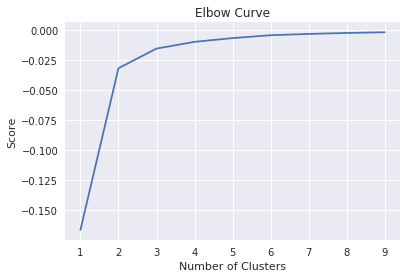

In [70]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = group_test_df[['lat']]
X_axis = group_test_df[['lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [71]:
kmeans = KMeans(n_clusters =15 , init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

ClientMacAddr        lat        lng                        localtime  \
0   b8:27:eb:14:a4:88 -22.813697 -43.247597 2019-11-19 00:00:00.197000+00:00   
2   40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.287000+00:00   
3   40:9b:cd:96:44:14 -22.813448 -43.247592 2019-11-19 00:00:00.288000+00:00   
4   8c:f7:10:f8:c6:86 -22.815071 -43.246684 2019-11-19 00:00:00.307000+00:00   
6   d4:c9:4b:97:da:a1 -22.815264 -43.245830 2019-11-19 00:00:00.380000+00:00   
8   70:fd:46:da:29:b6 -22.815295 -43.246316 2019-11-19 00:00:01.348000+00:00   
10  c0:a5:dd:17:fb:06 -22.815075 -43.245432 2019-11-19 00:00:01.550000+00:00   
12  c0:a5:dd:17:fb:e6 -22.814326 -43.246999 2019-11-19 00:00:01.551000+00:00   
14  34:69:87:12:42:b9 -22.815076 -43.245286 2019-11-19 00:00:02.266000+00:00   
16  38:01:95:38:cf:bc -22.813776 -43.247158 2019-11-19 00:00:02.287000+00:00   

    cluster_label  
0               7  
2              14  
3              14  
4               5  
6              11  
8              13  
10              1  
12              9  
14              8  
16              6

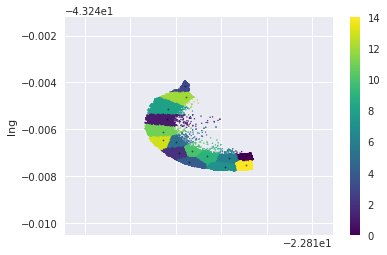

In [72]:
X.plot.scatter(x = 'lat', y = 'lng', c=labels, s=1, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=2, alpha=0.5)

In [73]:
X

ClientMacAddr        lat        lng  \
0       b8:27:eb:14:a4:88 -22.813697 -43.247597   
2       40:9b:cd:96:44:14 -22.813448 -43.247592   
3       40:9b:cd:96:44:14 -22.813448 -43.247592   
4       8c:f7:10:f8:c6:86 -22.815071 -43.246684   
6       d4:c9:4b:97:da:a1 -22.815264 -43.245830   
8       70:fd:46:da:29:b6 -22.815295 -43.246316   
10      c0:a5:dd:17:fb:06 -22.815075 -43.245432   
12      c0:a5:dd:17:fb:e6 -22.814326 -43.246999   
14      34:69:87:12:42:b9 -22.815076 -43.245286   
16      38:01:95:38:cf:bc -22.813776 -43.247158   
17      38:01:95:38:cf:bc -22.813776 -43.247158   
18      08:96:ad:db:dc:08 -22.815178 -43.246848   
20      00:05:9e:96:a9:fa -22.814613 -43.247464   
22      7c:5c:f8:f7:33:61 -22.814715 -43.246901   
24      b8:27:eb:6f:c2:6f -22.814536 -43.247013   
26      48:49:c7:c8:90:b8 -22.815051 -43.246340   
28      e0:9d:31:ab:11:14 -22.814964 -43.246580   
30      d0:04:01:01:39:43 -22.815315 -43.245127   
31      d0:04:01:01:39:43 -22.815315 -43.245127   
32      40:9b:cd:98:da:1c -22.815583 -43.245928   
33      40:9b:cd:98:da:1c -22.815583 -43.245928   
34      10:f1:f2:52:63:ca -22.814931 -43.244683   
36      30:4b:07:3e:ec:11 -22.814937 -43.245055   
38      00:1a:3f:19:05:52 -22.815055 -43.246451   
39      00:1a:3f:19:05:52 -22.815055 -43.246451   
40      a0:9d:c1:92:1f:5d -22.813963 -43.247112   
42      c0:25:e9:7f:32:c0 -22.814602 -43.247499   
44      c0:25:e9:7f:32:c1 -22.814788 -43.247375   
46      38:01:95:36:c0:aa -22.813347 -43.247069   
47      38:01:95:36:c0:aa -22.813347 -43.247069   
...                   ...        ...        ...   
451457  94:10:3e:0c:c2:f3 -22.813770 -43.247213   
451458  38:01:95:38:cf:bc -22.813882 -43.247192   
451460  f8:95:ea:37:48:0c -22.814746 -43.246842   
451462  b8:27:eb:fe:dc:66 -22.814800 -43.246998   
451464  10:d0:7a:7c:e0:65 -22.814811 -43.244018   
451466  38:01:95:37:74:e0 -22.814629 -43.244616   
451468  04:d4:c4:9d:4d:1f -22.814907 -43.244580   
451470  40:9b:cd:96:44:14 -22.813430 -43.247555   
451472  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451473  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451474  58:10:8c:82:56:27 -22.814374 -43.247489   
451475  58:10:8c:82:56:27 -22.814374 -43.247489   
451476  e0:9d:31:ab:0c:cc -22.814951 -43.246645   
451478  b8:27:eb:d5:29:27 -22.815147 -43.245825   
451480  70:fd:46:da:29:b6 -22.815368 -43.246009   
451482  0c:80:63:25:be:91 -22.814584 -43.246882   
451484  04:1b:6d:ad:d3:fe -22.814666 -43.247008   
451486  7c:5c:f8:f4:a0:83 -22.814745 -43.246910   
451488  da:0f:99:23:d7:ea -22.814933 -43.246523   
451490  c0:25:e9:7f:32:c0 -22.814731 -43.247407   
451492  fc:64:3a:75:b4:20 -22.815278 -43.245562   
451494  38:01:95:37:b4:ec -22.814383 -43.246999   
451495  38:01:95:37:b4:ec -22.814383 -43.246999   
451496  10:d0:7a:53:0a:f6 -22.813399 -43.247478   
451498  50:92:b9:0c:34:38 -22.815109 -43.246267   
451500  b0:be:76:2f:41:47 -22.813922 -43.247604   
451502  40:9b:cd:96:44:5f -22.813843 -43.247260   
451503  40:9b:cd:96:44:5f -22.813843 -43.247260   
451504  c0:a5:dd:17:fb:e6 -22.814484 -43.246923   
451506  d4:63:c6:4e:72:5b -22.814747 -43.244235   

                              localtime  cluster_label  
0      2019-11-19 00:00:00.197000+00:00              7  
2      2019-11-19 00:00:00.287000+00:00             14  
3      2019-11-19 00:00:00.288000+00:00             14  
4      2019-11-19 00:00:00.307000+00:00              5  
6      2019-11-19 00:00:00.380000+00:00             11  
8      2019-11-19 00:00:01.348000+00:00             13  
10     2019-11-19 00:00:01.550000+00:00              1  
12     2019-11-19 00:00:01.551000+00:00              9  
14     2019-11-19 00:00:02.266000+00:00              8  
16     2019-11-19 00:00:02.287000+00:00              6  
17     2019-11-19 00:00:02.288000+00:00              6  
18     2019-11-19 00:00:02.348000+00:00              2  
20     2019-11-19 00:00:03.243000+00:00              4  
22     2019-11-19 00:00:04.279000+00:00            

In [74]:
X_labeled = X[['ClientMacAddr','cluster_label']].copy()
X_labeled.head(5)

ClientMacAddr  cluster_label
0  b8:27:eb:14:a4:88              7
2  40:9b:cd:96:44:14             14
3  40:9b:cd:96:44:14             14
4  8c:f7:10:f8:c6:86              5
6  d4:c9:4b:97:da:a1             11

In [75]:
len(X_labeled['cluster_label'].unique())

15

In [76]:
 np.array(X_labeled.groupby(['ClientMacAddr']))

array([[u'00:05:16:59:ad:2b',
                    ClientMacAddr  cluster_label
19618   00:05:16:59:ad:2b             13
19944   00:05:16:59:ad:2b              5
269876  00:05:16:59:ad:2b             11
270000  00:05:16:59:ad:2b             11
270001  00:05:16:59:ad:2b             11
270082  00:05:16:59:ad:2b              1
270158  00:05:16:59:ad:2b              1
270234  00:05:16:59:ad:2b              1
270358  00:05:16:59:ad:2b              1
270434  00:05:16:59:ad:2b              1
270443  00:05:16:59:ad:2b              1
270502  00:05:16:59:ad:2b              1
270568  00:05:16:59:ad:2b              1
270722  00:05:16:59:ad:2b              1
270794  00:05:16:59:ad:2b             11
270866  00:05:16:59:ad:2b             11
270928  00:05:16:59:ad:2b             11
271018  00:05:16:59:ad:2b             11
271090  00:05:16:59:ad:2b             11
271160  00:05:16:59:ad:2b             11
271222  00:05:16:59:ad:2b             11
271304  00:05:16:59:ad:2b             13
271358  00:05:16:59

In [74]:
kmeans.inertia_

0.019133995438338214

In [75]:
kmeans.cluster_centers_

array([[-22.8151364 , -43.24524988],
       [-22.81487077, -43.24692928],
       [-22.81382394, -43.24719793],
       [-22.81478343, -43.2443707 ],
       [-22.81514819, -43.24642499],
       [-22.81342587, -43.24736987],
       [-22.814421  , -43.24702002],
       [-22.81471078, -43.24738588],
       [-22.81526059, -43.24571095],
       [-22.81389052, -43.24757906]])

In [76]:
kmeans.labels_

array([9, 9, 5, ..., 6, 3, 3], dtype=int32)

In [77]:
x_lat_lng = X.copy()

In [78]:
x_lat_lng

ClientMacAddr        lat        lng  \
0       b8:27:eb:14:a4:88 -22.813697 -43.247597   
2       40:9b:cd:96:44:14 -22.813448 -43.247592   
3       40:9b:cd:96:44:14 -22.813448 -43.247592   
4       8c:f7:10:f8:c6:86 -22.815071 -43.246684   
6       d4:c9:4b:97:da:a1 -22.815264 -43.245830   
8       70:fd:46:da:29:b6 -22.815295 -43.246316   
10      c0:a5:dd:17:fb:06 -22.815075 -43.245432   
12      c0:a5:dd:17:fb:e6 -22.814326 -43.246999   
14      34:69:87:12:42:b9 -22.815076 -43.245286   
16      38:01:95:38:cf:bc -22.813776 -43.247158   
17      38:01:95:38:cf:bc -22.813776 -43.247158   
18      08:96:ad:db:dc:08 -22.815178 -43.246848   
20      00:05:9e:96:a9:fa -22.814613 -43.247464   
22      7c:5c:f8:f7:33:61 -22.814715 -43.246901   
24      b8:27:eb:6f:c2:6f -22.814536 -43.247013   
26      48:49:c7:c8:90:b8 -22.815051 -43.246340   
28      e0:9d:31:ab:11:14 -22.814964 -43.246580   
30      d0:04:01:01:39:43 -22.815315 -43.245127   
31      d0:04:01:01:39:43 -22.815315 -43.245127   
32      40:9b:cd:98:da:1c -22.815583 -43.245928   
33      40:9b:cd:98:da:1c -22.815583 -43.245928   
34      10:f1:f2:52:63:ca -22.814931 -43.244683   
36      30:4b:07:3e:ec:11 -22.814937 -43.245055   
38      00:1a:3f:19:05:52 -22.815055 -43.246451   
39      00:1a:3f:19:05:52 -22.815055 -43.246451   
40      a0:9d:c1:92:1f:5d -22.813963 -43.247112   
42      c0:25:e9:7f:32:c0 -22.814602 -43.247499   
44      c0:25:e9:7f:32:c1 -22.814788 -43.247375   
46      38:01:95:36:c0:aa -22.813347 -43.247069   
47      38:01:95:36:c0:aa -22.813347 -43.247069   
...                   ...        ...        ...   
451457  94:10:3e:0c:c2:f3 -22.813770 -43.247213   
451458  38:01:95:38:cf:bc -22.813882 -43.247192   
451460  f8:95:ea:37:48:0c -22.814746 -43.246842   
451462  b8:27:eb:fe:dc:66 -22.814800 -43.246998   
451464  10:d0:7a:7c:e0:65 -22.814811 -43.244018   
451466  38:01:95:37:74:e0 -22.814629 -43.244616   
451468  04:d4:c4:9d:4d:1f -22.814907 -43.244580   
451470  40:9b:cd:96:44:14 -22.813430 -43.247555   
451472  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451473  28:ed:e0:8a:d4:a9 -22.813427 -43.247359   
451474  58:10:8c:82:56:27 -22.814374 -43.247489   
451475  58:10:8c:82:56:27 -22.814374 -43.247489   
451476  e0:9d:31:ab:0c:cc -22.814951 -43.246645   
451478  b8:27:eb:d5:29:27 -22.815147 -43.245825   
451480  70:fd:46:da:29:b6 -22.815368 -43.246009   
451482  0c:80:63:25:be:91 -22.814584 -43.246882   
451484  04:1b:6d:ad:d3:fe -22.814666 -43.247008   
451486  7c:5c:f8:f4:a0:83 -22.814745 -43.246910   
451488  da:0f:99:23:d7:ea -22.814933 -43.246523   
451490  c0:25:e9:7f:32:c0 -22.814731 -43.247407   
451492  fc:64:3a:75:b4:20 -22.815278 -43.245562   
451494  38:01:95:37:b4:ec -22.814383 -43.246999   
451495  38:01:95:37:b4:ec -22.814383 -43.246999   
451496  10:d0:7a:53:0a:f6 -22.813399 -43.247478   
451498  50:92:b9:0c:34:38 -22.815109 -43.246267   
451500  b0:be:76:2f:41:47 -22.813922 -43.247604   
451502  40:9b:cd:96:44:5f -22.813843 -43.247260   
451503  40:9b:cd:96:44:5f -22.813843 -43.247260   
451504  c0:a5:dd:17:fb:e6 -22.814484 -43.246923   
451506  d4:63:c6:4e:72:5b -22.814747 -43.244235   

                              localtime  cluster_label  
0      2019-11-19 00:00:00.197000+00:00              7  
2      2019-11-19 00:00:00.287000+00:00             14  
3      2019-11-19 00:00:00.288000+00:00             14  
4      2019-11-19 00:00:00.307000+00:00              5  
6      2019-11-19 00:00:00.380000+00:00             11  
8      2019-11-19 00:00:01.348000+00:00             13  
10     2019-11-19 00:00:01.550000+00:00              1  
12     2019-11-19 00:00:01.551000+00:00              9  
14     2019-11-19 00:00:02.266000+00:00              8  
16     2019-11-19 00:00:02.287000+00:00              6  
17     2019-11-19 00:00:02.288000+00:00              6  
18     2019-11-19 00:00:02.348000+00:00              2  
20     2019-11-19 00:00:03.243000+00:00              4  
22     2019-11-19 00:00:04.279000+00:00            

In [79]:

centroids,clusters,x_lat_lng
clusters.sort()
clusters

array([ 0,  0,  0, ..., 14, 14, 14], dtype=int32)

In [81]:

clusters=kmeans.fit_predict(x_lat_lng[['lat','lng']])
centroids = kmeans.cluster_centers_
centroids

array([[-22.8134436 , -43.24713354],
       [-22.81516206, -43.24506723],
       [-22.81506486, -43.2465416 ],
       [-22.8147966 , -43.24416731],
       [-22.81491295, -43.24701354],
       [-22.81383188, -43.24720567],
       [-22.81476324, -43.24461736],
       [-22.81464377, -43.2469116 ],
       [-22.81390661, -43.24758297],
       [-22.81527133, -43.24626468],
       [-22.8143069 , -43.24710502],
       [-22.8146962 , -43.24740418],
       [-22.81344709, -43.24752432],
       [-22.81512494, -43.24538888],
       [-22.81525132, -43.24568707]])

def k_mean_distance(x,y):
        global centroids
        

        distances = [np.sqrt((x-a)**2+(y-b)**2) for a, b in centroids]
        return( min(distances))

## Haversine distance based clustering of employee macids to get real group data

In [82]:
from math import sin, cos, sqrt, atan2, radians

In [83]:
def k_mean_distance(x,y):
    global centroids 
    distances = []
    for p,q in centroids:
        # approximate radius of earth in km
        R = 6373.0

        lat1 = radians(x)
        lon1 = radians(y)
        lat2 = radians(p)
        lon2 = radians(q)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        #distance = R * c
        distances.append(R * c)
    return( min(distances))

In [84]:
group_reverse_sparkDF = sqlContext.createDataFrame(x_lat_lng)
group_reverse_sparkRDD = group_reverse_sparkDF.rdd.map(list)

In [85]:
group_reverse_sparkRDD.take(2)

[[u'b8:27:eb:14:a4:88',
  -22.81369714064852,
  -43.2475968613329,
  datetime.datetime(2019, 11, 19, 0, 0, 0, 197000),
  7],
 [u'40:9b:cd:96:44:14',
  -22.813447900941867,
  -43.247591854681204,
  datetime.datetime(2019, 11, 19, 0, 0, 0, 287000),
  14]]

In [86]:
group_euc_rdd = group_reverse_sparkRDD.map(lambda x: (x[0],x[1],x[2],k_mean_distance(x[1],x[2]),x[3],x[4])).sortBy(lambda x :x[3]).filter(lambda x:x[3] <0.006)

In [87]:
group_euc_rdd.map(lambda x: (x[0],1)).reduceByKey(lambda x,y:x).count()
#.takeOrdered(5, key = lambda x: -x[3])

454

In [88]:
jsonRDD = group_euc_rdd.map(json.dumps)

json_string = jsonRDD.reduce(lambda x, y: x + "\n" + y)
json_string

with open("gs://testdatakiana/groupDataFile.json", "w") as f:
    f.write(json_string.encode("utf-8"))

In [54]:
group_euc_rdd.take(3)

[(u'60:14:66:a8:96:22',
  -22.815253224215272,
  -43.24569371855513,
  4.494756718317526e-05,
  5),
 (u'e0:9d:31:ab:0c:cc',
  -22.815039978266668,
  -43.24654118646064,
  6.640697762283123e-05,
  4),
 (u'00:16:98:70:af:85',
  -22.814797405479837,
  -43.244167021032005,
  6.871726008138033e-05,
  3)]

In [93]:
employers_df_spark = group_euc_rdd.toDF(["ClientMacAddr","lat","lng","distance_centroid","localtime","cluster"])
employers_DF=employers_df_spark.toPandas()

In [124]:
group_euc_rdd.count()

26063

In [ ]:
TPS1_rdd_1_day_final=group_euc_rdd.map(lambda x : (x['ClientMacAddr'],1)).reduceByKey(add).filter(lambda x : x[1]>=10) #ignoring mac address with less then 10 frequency count

In [94]:
employers_DF

ClientMacAddr        lat        lng  distance_centroid  \
0      54:b8:0a:92:30:50 -22.815065 -43.246542           0.000013   
1      c8:d7:19:fc:32:1a -22.814644 -43.246912           0.000068   
2      74:2f:68:05:bf:b9 -22.815064 -43.246542           0.000075   
3      34:fc:ef:ae:b8:9c -22.814914 -43.247013           0.000082   
4      00:16:98:70:af:85 -22.814797 -43.244167           0.000095   
5      7c:5c:f8:f4:96:d8 -22.815126 -43.245389           0.000096   
6      c0:a5:dd:17:fb:e6 -22.814306 -43.247104           0.000099   
7      c0:a5:dd:17:fb:e6 -22.814307 -43.247106           0.000109   
8      38:9a:f6:82:87:65 -22.814797 -43.244168           0.000114   
9      c0:8c:71:bf:27:87 -22.814914 -43.247013           0.000120   
10     38:01:95:38:cf:bc -22.813832 -43.247204           0.000126   
11     38:01:95:37:74:e0 -22.814764 -43.244617           0.000137   
12     38:01:95:37:74:e0 -22.814763 -43.244616           0.000141   
13     60:14:66:a8:96:22 -22.815253 -43.245687           0.000158   
14     94:fb:29:05:83:1f -22.814912 -43.247012           0.000160   
15     c0:25:e9:7f:32:c1 -22.814695 -43.247403           0.000167   
16     c0:25:e9:7f:32:c1 -22.814695 -43.247403           0.000167   
17     10:f1:f2:94:10:f1 -22.814795 -43.244167           0.000167   
18     38:01:95:38:cf:bc -22.813831 -43.247207           0.000171   
19     54:b8:0a:92:30:50 -22.815066 -43.246542           0.000179   
20     38:01:95:38:cf:bc -22.813831 -43.247205           0.000180   
21     38:01:95:38:cf:bc -22.813831 -43.247205           0.000180   
22     60:14:66:a8:96:22 -22.815252 -43.245689           0.000180   
23     94:10:3e:0c:c2:f3 -22.813830 -43.247206           0.000181   
24     10:d0:7a:53:0a:f6 -22.813448 -43.247523           0.000187   
25     44:e4:ee:02:57:bb -22.814305 -43.247105           0.000189   
26     00:16:98:70:af:85 -22.814798 -43.244166           0.000189   
27     38:01:95:37:74:e0 -22.814763 -43.244615           0.000217   
28     c0:25:e9:7f:32:c1 -22.814694 -43.247404           0.000220   
29     c8:d7:19:fc:32:1a -22.814645 -43.246913           0.000222   
...                  ...        ...        ...                ...   
26033  d0:77:14:ec:2e:6e -22.815301 -43.245664           0.005997   
26034  28:83:35:cb:b5:81 -22.815083 -43.246486           0.005997   
26035  c0:25:e9:7f:32:c1 -22.814729 -43.247451           0.005997   
26036  c0:25:e9:7f:32:c1 -22.814743 -43.247433           0.005997   
26037  7c:5c:f8:f4:96:d8 -22.815118 -43.245101           0.005997   
26038  b8:27:eb:d5:29:27 -22.815079 -43.245420           0.005997   
26039  b8:27:eb:d5:29:27 -22.815079 -43.245420           0.005997   
26040  38:01:95:36:c0:aa -22.813402 -43.247096           0.005997   
26041  e4:11:5b:90:32:6e -22.814816 -43.244222           0.005997   
26042  7c:5c:f8:17:16:64 -22.815138 -43.245120           0.005997   
26043  68:14:01:fe:9f:6f -22.813815 -43.247150           0.005998   
26044  00:05:9e:96:a9:fa -22.814750 -43.247403           0.005998   
26045  00:1a:3f:f8:f7:6d -22.814815 -43.244635           0.005998   
26046  54:b8:0a:92:30:50 -22.815042 -43.246595           0.005998   
26047  e4:11:5b:90:32:6e -22.814828 -43.244215           0.005998   
26048  38:01:95:38:cf:bc -22.813778 -43.247209           0.005998   
26049  00:05:9e:96:a9:fa -22.814749 -43.247392           0.005998   
26050  44:e4:ee:02:55:b7 -22.815080 -43.245421           0.005998   
26051  44:2b:03:7e:64:28 -22.815045 -43.246596           0.005998   
26052  44:e4:ee:02:55:b7 -22.815080 -43.245422           0.005998   
26053  c0:a5:dd:17:fb:06 -22.815083 -43.245426           0.005999   
26054  e4:11:5b:90:32:6e -22.814851 -43.244169           0.005999   
26055  44:e4:ee:02:57:bb -22.814328 -43.247051           0.005999   
26056  54:b8:0a:92:30:50 -22.815119 -43.246536           0.005999   
26057  38:01:95:36:c0:aa -22.813469 -43.247082           0.005999   
26058  28:ed:e0:8a:d4:a9 -22.813422 -43.247473           0.006000   
26059  f0

Implemented on google cloud platform. Saved all output to json file to be usable at later testing phases

In [100]:
from google.cloud import storage

from io import BytesIO

storage_client = storage.Client(project = 'e-resolver-273005')

bucket =storage_client.get_bucket("testdatakiana")

In [111]:
employers_DF.to_pickle("employers_DF.json")
blob = storage.blob.Blob("gs://testdatakiana/groupDataFile.json",bucket)
#blob1 = bucket('employers_DF.pkl')
blob.upload_from_filename('employers_DF.json')

In [114]:
employers_DF.shape

(26063, 6)